# **Install Dependencies**

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [ ]:
!pip install sacrebleu  rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e348f130ba95763e740c4fc4eb8111a3298bfd8c8d4847110f189f5c621e6463
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


# **Import Libraries**

In [ ]:
import torch
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainerCallback,
)
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
from rouge_score import rouge_scorer
import json
import glob
import time
import unicodedata
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings
warnings.filterwarnings('ignore')

2025-05-02 19:11:00.936316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746213061.126225      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746213061.186900      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Analysis and Cleaning**

In [ ]:
df = pd.read_parquet("hf://datasets/damerajee/english-to-hindi-l/data/train-00000-of-00001.parquet")

In [ ]:
df.head()

,english_sentence,hindi_sentence
0,When it is said to him: 'Fear Allah' egotism t...,"और जब उससे कहा जाता है, ""अल्लाह से डर"", तो अहं..."
1,This profile exists already.,यह प्रोफ़ाइल पहले से ही है.
2,Halo with Ornamental Borde,विवरण: एक पारंपरिक कमल के फूल के साथ पत्थर की ...
3,and the jinn We had created before from flamin...,और हम ही ने जिन्नात को आदमी से (भी) पहले वे धु...
4,"Ladies and Gentlemen, the Government of India ...",शहरीकरण की तेज गति के साथ अवसंरचना और सेवाओं क...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786788 entries, 0 to 1786787
Data columns (total 2 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   english_sentence  object
 1   hindi_sentence    object
dtypes: object(2)
memory usage: 27.3+ MB


In [ ]:
df.isnull().sum()

english_sentence    0
hindi_sentence      0
dtype: int64

In [ ]:
df.duplicated().sum()

238016

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
len(df)

1548772

In [ ]:
def clean(text: str) -> str:
    text = unicodedata.normalize("NFKC", text)

    text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')

    text = re.sub(r'\d+', '', text)

    # Keep English, Hindi (Devanagari block), basic punctuation, and whitespace
    text = re.sub(r'[^\w\s\u0900-\u097F.,!?;:]', '', text)

    text = re.sub(r'\s+', ' ', text)

    return text.strip()
df['english_sentence']=df['english_sentence'].apply(clean)
df['hindi_sentence']=df['hindi_sentence'].apply(clean)

In [ ]:
df.head(10)

,english_sentence,hindi_sentence
0,When it is said to him: Fear Allah egotism tak...,"और जब उससे कहा जाता है, अल्लाह से डर, तो अहंका..."
1,This profile exists already.,यह प्रोफ़ाइल पहले से ही है.
2,Halo with Ornamental Borde,विवरण: एक पारंपरिक कमल के फूल के साथ पत्थर की ...
3,and the jinn We had created before from flamin...,और हम ही ने जिन्नात को आदमी से भी पहले वे धुएँ...
4,"Ladies and Gentlemen, the Government of India ...",शहरीकरण की तेज गति के साथ अवसंरचना और सेवाओं क...
5,"Have you then considered Al Lat, and Al Uzza t...",तो क्या तुमने लात और उज़्ज़ा
6,Escalation in demand will provide traders an o...,मांग में वृद्धि व्यापारियों को कीमतें बढाने का...
7,He understood the pity and the beauty of life ...,वे जीवन में अनुकम्पा और सौन्दर्य के महत्व को स...
8,Fast Track Court The Additional Sessions Court...,फास्ट ट्रेक कोर्टये अतिरिक्त सत्र न्यायालय है ...
9,He was working as a quality controller in the ...,वह खाद्य उत्पादन कारखाने में गुणवत्ता नियंत्रक...


# **Data Preparation**

* Data Splitting

In [ ]:
df['total_length'] = df['english_sentence'].str.len() + df['hindi_sentence'].str.len()
df = df.sort_values(by='total_length', ascending=False).head(30000).reset_index(drop=True)
df.drop(columns='total_length', inplace=True)

train_df = df.iloc[:25000]
val_df = df.iloc[25000:27000]
test_df = df.iloc[27000:30000]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 25000 rows
Validation set: 2000 rows
Test set: 3000 rows


* Model and Tokenizer Initialization

In [ ]:
# bnb_config = BitsAndBytesConfig(load_in_8bit=True)
model_name="Helsinki-NLP/opus-mt-en-hi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
print(f"Number of encoder layers: {len(model.model.encoder.layers)}")
print(f"Number of decoder layers: {len(model.model.decoder.layers)}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/all_params:.2%})")

Number of encoder layers: 6
Number of decoder layers: 6
Trainable parameters: 76,381,184 (100.00%)


In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

* Data Preprocessing

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
def preprocess_function(examples):
    inputs = examples["english_sentence"]
    targets = examples["hindi_sentence"]

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
import os
!mkdir /kaggle/working/results
!mkdir /kaggle/working/results/best
!mkdir /kaggle/working/models

# **Callbacks - Helper Functions**

* Available Training Parameters  - Version-based

In [ ]:
try:
    import inspect
    print("Available parameters for Seq2SeqTrainingArguments:")
    sig = inspect.signature(Seq2SeqTrainingArguments.__init__)
    print(list(sig.parameters.keys()))
except Exception as e:
    print(f"Couldn't inspect parameters: {e}")

Available parameters for Seq2SeqTrainingArguments:
['self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 

* Evaluation Metrics

In [ ]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
def compute_metrics(eval_pred):
    preds, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    bleu_result = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )

    rouge_result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    result = {
        "bleu": bleu_result["bleu"],
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
    }

    return result

* In-Training Evaluation Callbacks

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

class PrintEpochCallback(TrainerCallback):
    def __init__(self):
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        print(f"Starting Epoch {state.epoch:.2f}")

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.epoch_start_time:
            duration = time.time() - self.epoch_start_time
            print(f"Epoch {state.epoch-1:.2f} time: {duration:.2f} seconds")

class MemoryCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"[Step {state.global_step}] Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB")

class EvalEveryNStepsCallback(TrainerCallback):
    def __init__(self, eval_steps=500):
        self.eval_steps = eval_steps

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.eval_steps == 0 and state.global_step != 0:
            control.should_evaluate = True
        if state.global_step == state.max_steps:
            control.should_evaluate = True

        return control

In [ ]:
import os
os.environ["WANDB_MODE"] = "offline"

# **Hyperparameters Tuning Results**

**Best Parameters:**

- **Learning Rate:** `5e-05`  
- **Batch Size:** `16`  
- **Weight Decay:** `0.1`  

**With the highest BLEU score**

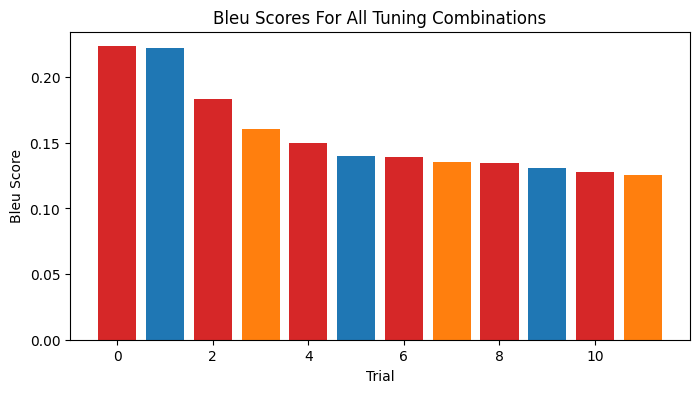

In [ ]:
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
plt.figure(figsize=(8, 4))
plt.bar(range(len(bleu_scores)), bleu_scores, color=bar_colors)
plt.xlabel("Trial")
plt.ylabel("Bleu Score")
plt.title("Bleu Scores For All Tuning Combinations")
plt.show()

In [ ]:
best_params={
    "learning_rate":5e-5,
    'batch_size':16,
    "weight_decay":0.1,
}

# **Training Using Best Parameters**

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/results/best",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    predict_with_generate=True,
    learning_rate=best_params['learning_rate'],
    max_grad_norm=0.5,
    weight_decay=best_params['weight_decay'],
    adam_beta1=0.95,
    num_train_epochs=25,
    save_steps=100,
    save_total_limit=1,
    generation_num_beams=5,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EvalEveryNStepsCallback(eval_steps=1200),
               PrintEpochCallback,
               MemoryCallback,
              ],
)

In [ ]:
print('Starting Fine Tuning......')
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Starting Fine Tuning......


wandb: Tracking run with wandb version 0.19.6
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Starting Epoch 0.00


Epoch 0.00 time: 392.90 seconds
[Step 782] Allocated: 0.87 GB | Reserved: 4.48 GB
Starting Epoch 1.00
Epoch 1.00 time: 1461.38 seconds
[Step 1564] Allocated: 0.88 GB | Reserved: 7.84 GB
Starting Epoch 2.00
Epoch 2.00 time: 398.16 seconds
[Step 2346] Allocated: 0.88 GB | Reserved: 7.84 GB
Starting Epoch 3.00
Epoch 3.00 time: 844.38 seconds
[Step 3128] Allocated: 0.88 GB | Reserved: 7.84 GB
Starting Epoch 4.00
Epoch 4.00 time: 698.77 seconds
[Step 3910] Allocated: 0.88 GB | Reserved: 7.84 GB
Starting Epoch 5.00
Epoch 5.00 time: 396.47 seconds
[Step 4692] Allocated: 0.88 GB | Reserved: 7.84 GB
Starting Epoch 6.00
Epoch 6.00 time: 613.43 seconds
[Step 5474] Allocated: 0.88 GB | Reserved: 7.84 GB
Starting Epoch 7.00
Epoch 7.00 time: 712.19 seconds
[Step 6256] Allocated: 0.88 GB | Reserved: 7.84 GB
Starting Epoch 8.00
Epoch 8.00 time: 398.05 seconds
[Step 7038] Allocated: 0.88 GB | Reserved: 7.84 GB
Starting Epoch 9.00
Epoch 9.00 time: 900.80 seconds
[Step 7820] Allocated: 0.88 GB | Reserved

TrainOutput(global_step=19550, training_loss=0.9714558893579351, metrics={'train_runtime': 16984.7574, 'train_samples_per_second': 36.798, 'train_steps_per_second': 1.151, 'total_flos': 2.118647808e+16, 'train_loss': 0.9714558893579351, 'epoch': 25.0})

# **Results Visualization**

In [ ]:
base_path = "/kaggle/working/results/best"
checkpoints = glob.glob(os.path.join(base_path, "checkpoint-*"))
checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))
latest_checkpoint = checkpoints[-1]
log_path = os.path.join(latest_checkpoint, "trainer_state.json")

with open(log_path, "r") as f:
    state = json.load(f)

log_history = state["log_history"]

df_logs = pd.DataFrame(log_history)

In [ ]:
df_logs.head()

,epoch,grad_norm,learning_rate,loss,step,eval_bleu,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.639386,1.350011,0.000049,2.4016,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.278772,1.396333,0.000047,1.9656,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.534527,NaN,NaN,NaN,1200,0.269994,1.325117,0.01001,0.001188,0.010018,1064.3652,1.879,0.059
3,1.918159,1.255687,0.000046,1.7770,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.557545,1.403602,0.000045,1.6161,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_logs["eval_bleu"]

0          NaN
1          NaN
2     0.269994
3          NaN
4          NaN
5     0.319138
6          NaN
7          NaN
8          NaN
9     0.332018
10         NaN
11         NaN
12    0.337410
13         NaN
14         NaN
15         NaN
16    0.333496
17         NaN
18         NaN
19    0.304497
20         NaN
21         NaN
22    0.336670
23         NaN
24         NaN
25         NaN
26    0.328402
27         NaN
28         NaN
29    0.336941
30         NaN
31         NaN
32         NaN
33    0.328828
34         NaN
35         NaN
36    0.330713
37         NaN
38         NaN
39    0.334483
40         NaN
41         NaN
42         NaN
43    0.349032
Name: eval_bleu, dtype: float64

In [ ]:
df_logs["loss"]

0     2.4016
1     1.9656
2        NaN
3     1.7770
4     1.6161
5        NaN
6     1.5156
7     1.4149
8     1.3349
9        NaN
10    1.2727
11    1.1924
12       NaN
13    1.1584
14    1.1199
15    1.0468
16       NaN
17    1.0157
18    0.9965
19       NaN
20    0.9440
21    0.9088
22       NaN
23    0.8934
24    0.8479
25    0.8456
26       NaN
27    0.8170
28    0.7900
29       NaN
30    0.7808
31    0.7500
32    0.7364
33       NaN
34    0.7294
35    0.7055
36       NaN
37    0.6958
38    0.6839
39       NaN
40    0.6718
41    0.6660
42    0.6525
43       NaN
Name: loss, dtype: float64

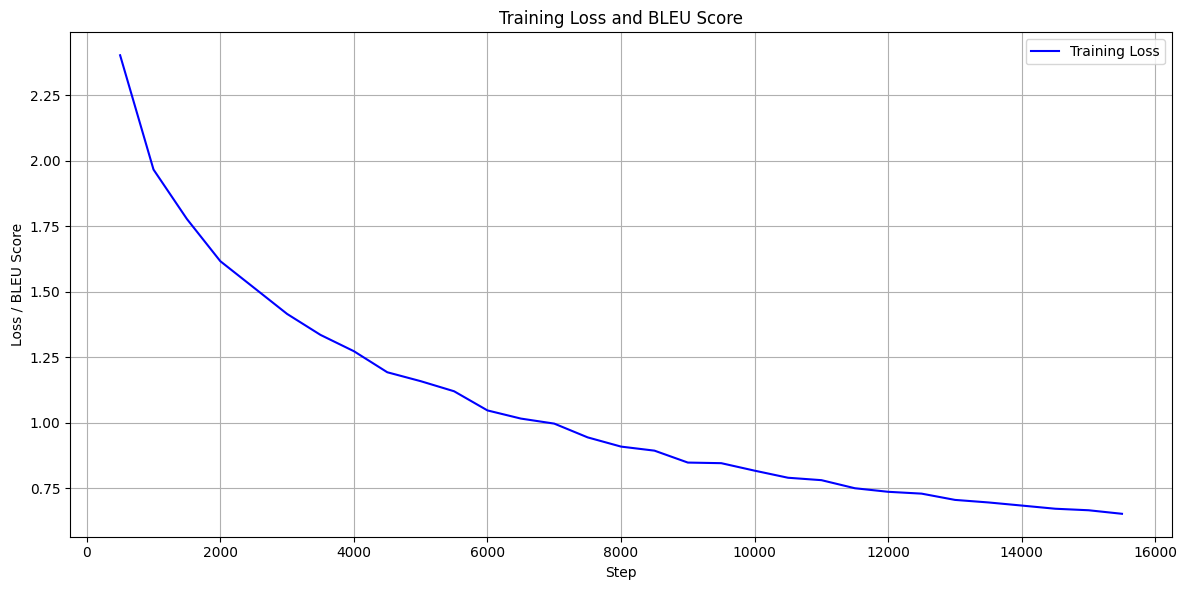

In [ ]:
plt.figure(figsize=(12, 6))

# Training Loss
plt.plot(df_logs.dropna(subset=["loss"])["step"],
         df_logs.dropna(subset=["loss"])["loss"], label="Training Loss", color="blue")
plt.xlabel("Step")
plt.ylabel("Loss / BLEU Score")
plt.title("Training Loss and BLEU Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

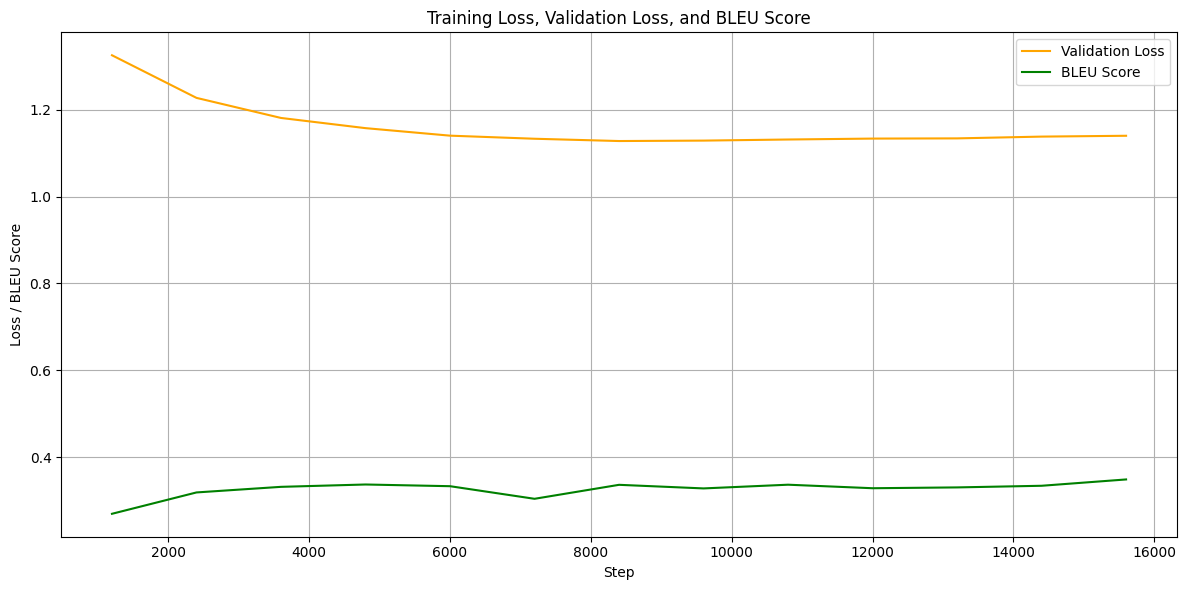

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_logs.dropna(subset=["eval_loss"])["step"],
         df_logs.dropna(subset=["eval_loss"])["eval_loss"],
         label="Validation Loss", color="orange")

plt.plot(df_logs.dropna(subset=["eval_bleu"])["step"],
         df_logs.dropna(subset=["eval_bleu"])["eval_bleu"],
         label="BLEU Score", color="green")

plt.xlabel("Step")
plt.ylabel("Loss / BLEU Score")
plt.title("Training Loss, Validation Loss, and BLEU Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

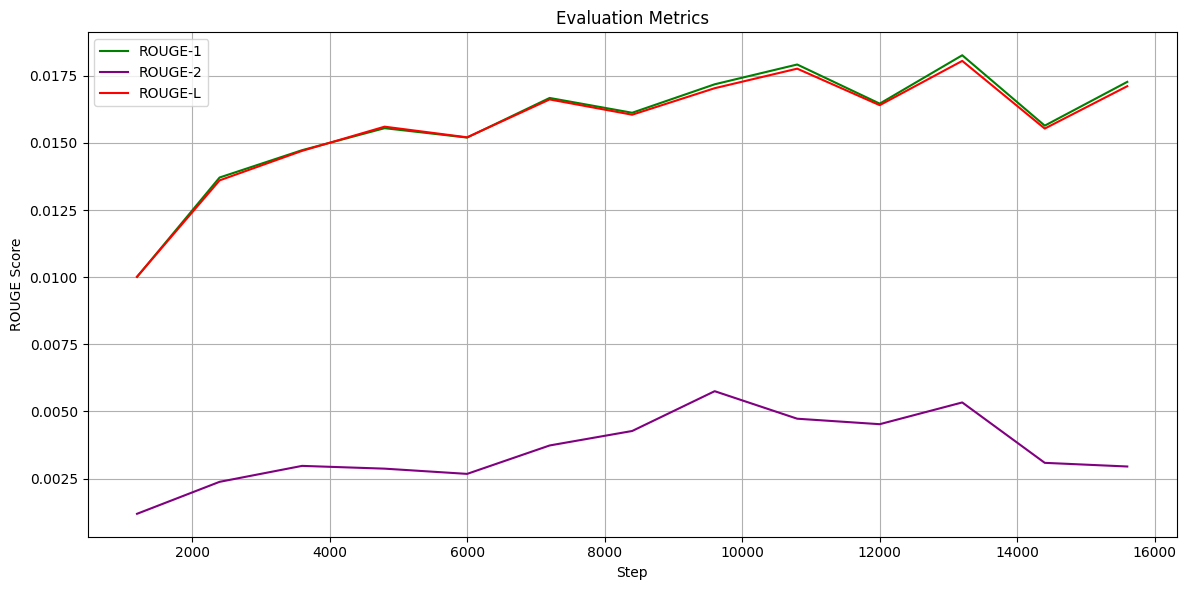

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_logs.dropna(subset=["eval_rouge1"])["step"],
         df_logs.dropna(subset=["eval_rouge1"])["eval_rouge1"],
         label="ROUGE-1", color="green")

plt.plot(df_logs.dropna(subset=["eval_rouge2"])["step"],
         df_logs.dropna(subset=["eval_rouge2"])["eval_rouge2"],
         label="ROUGE-2", color="purple")

plt.plot(df_logs.dropna(subset=["eval_rougeL"])["step"],
         df_logs.dropna(subset=["eval_rougeL"])["eval_rougeL"],
         label="ROUGE-L", color="red")

plt.xlabel("Step")
plt.ylabel("ROUGE Score")
plt.title("Evaluation Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# **Evaluation and Inference**

In [ ]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 1.1433521509170532, 'eval_bleu': 0.3447412628975694, 'eval_rouge1': 0.016145268682185517, 'eval_rouge2': 0.003112731481481482, 'eval_rougeL': 0.015998841281549193, 'eval_runtime': 344.7143, 'eval_samples_per_second': 5.802, 'eval_steps_per_second': 0.183, 'epoch': 25.0}


In [ ]:
# Predict
predictions = trainer.predict(test_dataset)
decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

label_ids = predictions.label_ids
label_ids[label_ids == -100] = tokenizer.pad_token_id  # or just 0
decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

results = rouge_metric.compute(predictions=[" ".join(pred.split()) for pred in decoded_preds],
                                references=[[" ".join(ref.split())] for ref in decoded_labels])
for key in results:
    print(f"{key}: {results[key]:.4f}")

bleu_score = bleu_metric.compute(predictions=[" ".join(pred.split()) for pred in decoded_preds],
                          references=[[" ".join(ref.split())] for ref in decoded_labels])
print(f"BLEU: {bleu_score['bleu']:.4f}")

rouge1: 0.0230
rouge2: 0.0040
rougeL: 0.0228
rougeLsum: 0.0228
BLEU: 0.3101


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

input_sentence = "hello guys"
inputs = tokenizer(input_sentence, return_tensors="pt", truncation=True, padding=True)

inputs = {key: value.to(device) for key, value in inputs.items()}

outputs = model.generate(**inputs)

decoded_pred = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"English: {input_sentence} => Predicted Translation: {decoded_pred}")

English: hello guys => Predicted Translation: सलाम लोग. सलाम करने वालें आदमी


In [ ]:
input_sentence = "Artificial intelligence is transforming the way we live and work. It is enabling machines to learn from data, make decisions, and even improve themselves over time. As AI technology advances, it holds the potential to solve complex problems in various fields, from healthcare to education, and beyond. However, it also brings challenges, such as ethical concerns and job displacement, that need to be addressed carefully."

reference_translation = "आर्टिफिशियल इंटेलिजेंस हमारे जीने और काम करने के तरीके को बदल रहा है। यह मशीनों को डेटा से सीखने, निर्णय लेने और समय के साथ खुद को बेहतर बनाने में सक्षम बना रहा है। जैसे-जैसे एआई तकनीक आगे बढ़ रही है, इसमें स्वास्थ्य सेवा से लेकर शिक्षा तक और उससे आगे के विभिन्न क्षेत्रों में जटिल समस्याओं को हल करने की क्षमता है। हालांकि, यह नैतिक चिंताओं और नौकरियों के नुकसान जैसी चुनौतियाँ भी लेकर आता है, जिन्हें सावधानीपूर्वक संबोधित करना आवश्यक है।"
inputs = tokenizer(input_sentence, return_tensors="pt", truncation=True, padding=True)

inputs = {key: value.to(device) for key, value in inputs.items()}
outputs = model.generate(**inputs)

predicted_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Input for Translation: {input_sentence}")
print('=============================')
print(f"Reference Translation: {reference_translation}")
print('=============================')
print(f"Predicted Translation: {predicted_translation}")
print('=============================')

formatted_pred = [" ".join(predicted_translation.split())]  # Predicted sentence
formatted_ref = [[" ".join(reference_translation.split())]]  # Reference translation

bleu_score = bleu_metric.compute(predictions=formatted_pred, references=formatted_ref)
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print('=============================')

rouge_score = rouge_metric.compute(predictions=formatted_pred, references=formatted_ref)

for key in rouge_score:
    print(f"{key}: {rouge_score[key]:.4f}")

Input for Translation: Artificial intelligence is transforming the way we live and work. It is enabling machines to learn from data, make decisions, and even improve themselves over time. As AI technology advances, it holds the potential to solve complex problems in various fields, from healthcare to education, and beyond. However, it also brings challenges, such as ethical concerns and job displacement, that need to be addressed carefully.
Reference Translation: आर्टिफिशियल इंटेलिजेंस हमारे जीने और काम करने के तरीके को बदल रहा है। यह मशीनों को डेटा से सीखने, निर्णय लेने और समय के साथ खुद को बेहतर बनाने में सक्षम बना रहा है। जैसे-जैसे एआई तकनीक आगे बढ़ रही है, इसमें स्वास्थ्य सेवा से लेकर शिक्षा तक और उससे आगे के विभिन्न क्षेत्रों में जटिल समस्याओं को हल करने की क्षमता है। हालांकि, यह नैतिक चिंताओं और नौकरियों के नुकसान जैसी चुनौतियाँ भी लेकर आता है, जिन्हें सावधानीपूर्वक संबोधित करना आवश्यक है।
Predicted Translation: कला की गुप्तचरिता हमारे जीवन और कार्य को बदल रही है. यह मशीनों को आं

# **Save Training Results**

In [ ]:
save_path = "/kaggle/working/models"

In [ ]:
trainer.save_model(save_path)
trainer.save_state()
tokenizer.save_pretrained(save_path)

('/kaggle/working/models/tokenizer_config.json',
 '/kaggle/working/models/special_tokens_map.json',
 '/kaggle/working/models/vocab.json',
 '/kaggle/working/models/source.spm',
 '/kaggle/working/models/target.spm',
 '/kaggle/working/models/added_tokens.json')

In [ ]:
trainer.state.save_to_json(f"{save_path}/trainer_state.json")

In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained(save_path)
model2 = AutoModelForSeq2SeqLM.from_pretrained(save_path)

In [ ]:
input_text = "Translate English to Hindi: How are you?"

inputs = tokenizer2(input_text, return_tensors="pt")

output_tokens = model2.generate(
    **inputs,
    max_length=50,
    num_beams=4,
    early_stopping=True
)

output_text = tokenizer2.decode(output_tokens[0], skip_special_tokens=True)

print("Output:", output_text)

Output: हिंदी अनुवादः आप कैसे हैं?? आप कैसे हैं?? अंग्रेजी? हिन्दी अनुवाद???????????????????????????????
